In [77]:
import os
import sys
import pandas as pd
import numpy as np
from descartes import PolygonPatch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sys.path.insert(0, os.path.dirname(os.getcwd()))
import alphashape
import open3d as o3d
from shapely.geometry import Point
from PIL import Image
from statistics import mode
import helpers as hp

In [194]:
filename = '23.npy'
points = np.load('/home/christianforeman/catkin_ws/src/plant_selector/weed_eval/pcs/' + filename)
# green_points
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2])
# plt.show()

In [195]:
pcd_points = points[:, :3]
float_colors = points[:, 3]

pcd_colors = np.array((0, 0, 0))
for x in float_colors:
    rgb = hp.float_to_rgb(x)
    pcd_colors = np.vstack((pcd_colors, rgb))

# Alternate green color filter
pcd_colors = pcd_colors[1:, :]

# Filter the point cloud so that only the green points stay
# Get the indices of the points with g parameter greater than x
green_points_indices = np.where((pcd_colors[:, 1] - pcd_colors[:, 0] > pcd_colors[:, 1] / 12.0) &
                                (pcd_colors[:, 1] - pcd_colors[:, 2] > pcd_colors[:, 1] / 12.0))
green_points_xyz = pcd_points[green_points_indices]
green_points_rgb = pcd_colors[green_points_indices]

r_low, g_low, b_low = 10, 20, 10
r_high, g_high, b_high = 240, 240, 240
green_points_indices = np.where((green_points_rgb[:, 0] > r_low) & (green_points_rgb[:, 0] < r_high) &
                                (green_points_rgb[:, 1] > g_low) & (green_points_rgb[:, 1] < g_high) &
                                (green_points_rgb[:, 2] > b_low) & (green_points_rgb[:, 2] < b_high))

# Save xyzrgb info in green_points (type: numpy array)
green_points_xyz = green_points_xyz[green_points_indices]
green_points_rgb = green_points_rgb[green_points_indices]

# Create Open3D point cloud for green points
green_pcd = o3d.geometry.PointCloud()
# Save xyzrgb info in green_pcd (type: open3d.PointCloud)
green_pcd.points = o3d.utility.Vector3dVector(green_points_xyz)
green_pcd.colors = o3d.utility.Vector3dVector(green_points_rgb)

# Apply radius outlier filter to green_pcd
_, ind = green_pcd.remove_radius_outlier(nb_points=7, radius=0.007)


# Just keep the inlier points in the point cloud
green_pcd = green_pcd.select_by_index(ind)
green_pcd_points = np.asarray(green_pcd.points)

# Apply DBSCAN to green points
labels = np.array(green_pcd.cluster_dbscan(eps=0.0055, min_points=15))  # This is actually pretty good

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Get labels of the biggest cluster
biggest_cluster_indices = np.where(labels[:] == mode(labels))
# Just keep the points that correspond to the biggest cluster (weed)
green_pcd_points = green_pcd_points[biggest_cluster_indices]

# Get coordinates of the weed centroid
weed_centroid = np.mean(green_pcd_points, axis=0)

dirt_indices = np.arange(0, len(pcd_points))
# These are the indices for dirt
dirt_indices = np.setdiff1d(dirt_indices, green_points_indices)
# Save xyzrgb info in dirt_points (type: numpy array) from remaining indices of green points filter
dirt_points_xyz = pcd_points[dirt_indices]
dirt_points_rgb = pcd_colors[dirt_indices]
# Create PC for dirt points
dirt_pcd = o3d.geometry.PointCloud()
# Save points and color to the point cloud
dirt_pcd.points = o3d.utility.Vector3dVector(dirt_points_xyz)
dirt_pcd.colors = o3d.utility.Vector3dVector(dirt_points_rgb)

# Apply plane segmentation function from open3d and get the best inliers
plane_model, best_inliers = dirt_pcd.segment_plane(distance_threshold=0.0005,
                                                   ransac_n=3,
                                                   num_iterations=1000)

if len(best_inliers) == 0:
    rospy.loginfo("Can't find dirt, Select both weed and dirt.")
[a, b, c, _] = plane_model
if a < 0:
    normal = np.asarray([a, b, c])
else:
    normal = -np.asarray([a, b, c])

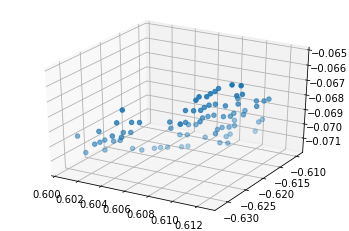

In [196]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(green_pcd_points[:, 0], green_pcd_points[:, 1], green_pcd_points[:, 2])
plt.show()

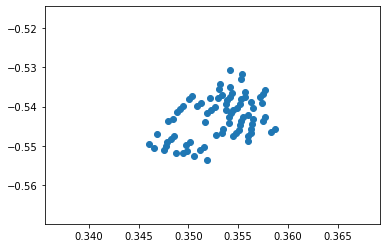

In [197]:
mat = hp.rotation_matrix_from_vectors(normal, np.asarray([0, 0, 1]))

rotated_points = (mat @ green_pcd_points.T).T
ax = plt.axes()
ax.scatter(rotated_points[:, 0], rotated_points[:, 1])
plt.show()

/home/christianforeman/catkin_ws/src/venv/lib/python3.8/site-packages/descartes/patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]
/home/christianforeman/catkin_ws/src/venv/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


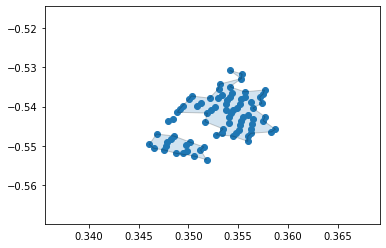

In [198]:
rotated_points_2d = rotated_points[:, :2]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(rotated_points_2d[:, 0], rotated_points_2d[:, 1])
alpha_shape = alphashape.alphashape(rotated_points_2d, 650)
ax.add_patch(PolygonPatch(alpha_shape, alpha=0.2))
plt.show()

In [199]:
points_2d = np.around(rotated_points_2d, 4)
min = np.amin(points_2d, axis=0)
max = np.amax(points_2d, axis=0)
rng = 10000 * (max - min)
img = np.zeros((int(rng[0]), int(rng[1]), 3), dtype=np.uint8)
x = min[0]
y = min[1]
for i in range(int(rng[0])):
    y = min[1]
    for j in range(int(rng[1])):
        point = Point(x, y)
        if alpha_shape.contains(point):
            img[i][j] = (255, 255, 255)
        y += 0.0001
    x += 0.0001
img_act = Image.fromarray(img, 'RGB')
img_act.show()

In [200]:
# calculate centroid
center = 10000 * (np.sum(points_2d, axis=0) / points_2d.shape[0] - min)
center = center.astype(int)
print(center)

[ 69 107]


In [201]:
#Calculate location of manual label
manual_label = np.load('/home/christianforeman/catkin_ws/src/plant_selector/weed_eval/manual_labels/' + filename)
manual_label_rot = (mat @ manual_label[:, :3].T).T[:, :2]
manual_label_rot = 10000 * (manual_label_rot - min)
manual_label_rot = manual_label_rot.astype(int).flatten()
print(manual_label_rot)

[ 98 113]


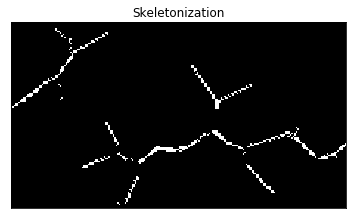

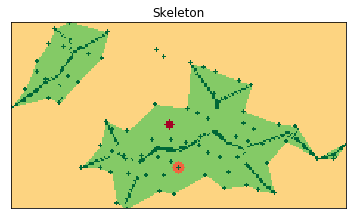

In [202]:
import cv2 as cv

weed = np.copy(img_act)
weed = cv.cvtColor(weed, cv.COLOR_RGB2GRAY)
final_img = np.copy(img_act)
final_img = cv.cvtColor(final_img, cv.COLOR_RGB2GRAY)
size = np.size(weed)

skel = np.zeros(weed.shape, np.uint8)
element = cv.getStructuringElement(cv.MORPH_CROSS, (5, 5))
done = False

while not done:
    eroded = cv.erode(weed, element)
    temp = cv.dilate(eroded, element)
    temp = cv.subtract(weed, temp)
    skel = cv.bitwise_or(skel, temp)
    weed = eroded.copy()

    zeros = size - cv.countNonZero(weed)
    if zeros == size:
        done = True
plt.figure(3)
plt.imshow(skel, cmap='gray')
plt.title('Skeletonization'), plt.xticks([]), plt.yticks([])
                
# Add in the centroid to the image
final_img = cv.circle(final_img, (manual_label_rot[1], manual_label_rot[0]), radius=4, color=(35), thickness=-1)
final_img = cv.circle(final_img, (center[1], center[0]), radius=3, color=(20), thickness=-1)
final_img[np.where(final_img == 0)] = 50
final_img[np.where(final_img == 255)] = 80
final_img[np.where(skel == 255)] = 100

for i in range(rotated_points_2d.shape[0]):
    point = (10000 * (rotated_points_2d[i, :] - min)).astype(int)
    final_img = cv.circle(final_img, (point[1], point[0]), radius=1, color=(100), thickness=-1)

plt.figure(4)
# rotated_points_2d_norm = (10000 * (rotated_points_2d - min)).astype(int)
# lt.scatter(rotated_points_2d_norm[:, 1], rotated_points_2d_norm[:, 0], c='green')
plt.imshow(final_img, cmap='RdYlGn')
plt.title('Skeleton'), plt.xticks([]), plt.yticks([])
plt.show()